# Plotting the Wind on Berwick Law

Using lidar data

In [1]:
# Import all the necessary libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv
from windrose import WindroseAxes
import warnings

warnings.filterwarnings('ignore')


In [2]:
# Parameters
topo_file_l = 'data/NBlidar8m.txt'       # Topography file name
dx = 8                    # ??? Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

# is 8m for dx correct (as the Lidar data has a 2m resolution orginally 
# but we averaged it over 8 m) and are L etc the same?

In [3]:
# Simulation with 1 m s$^{-1}$ wind from the west:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L/z0)**0.9
for i in range(10):
    l = 2*0.16*L/np.log(l/z0)
a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))

# Read the topography file, find size and take a Fourier transform
z = np.loadtxt(topo_file_l)
n = z.shape[0]
Fz = fft2(z)
Fz = fftshift(Fz)

# Wavenumbers and modified Bessel functions
k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
bu[int(n/2)] = 0
bv[int(n/2)] = 0

# Fourier components of u and v
Fu = np.zeros_like(Fz)
Fv = np.zeros_like(Fz)
for i in range(n):
    for j in range(n):
        r = np.sqrt(k[j]**2 + m[i]**2)
        if r != 0:
            Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
            Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

# Inverse Fourier transform
Fu = ifftshift(Fu)
Fv = ifftshift(Fv)
u = 1 + np.real(ifft2(Fu))
v = np.real(ifft2(Fv))
wind = np.sqrt(u**2 + v**2)

# Vertical wind component from continuity equation
w = np.zeros_like(wind)
dzdx = (z[1:-1,2:] - z[1:-1,:-2])/(2*dx)
dzdy = (z[2:,1:-1] - z[:-2,1:-1])/(2*dx)
w[1:-1,1:-1] = u[1:-1,1:-1]*dzdx + v[1:-1,1:-1]*dzdy

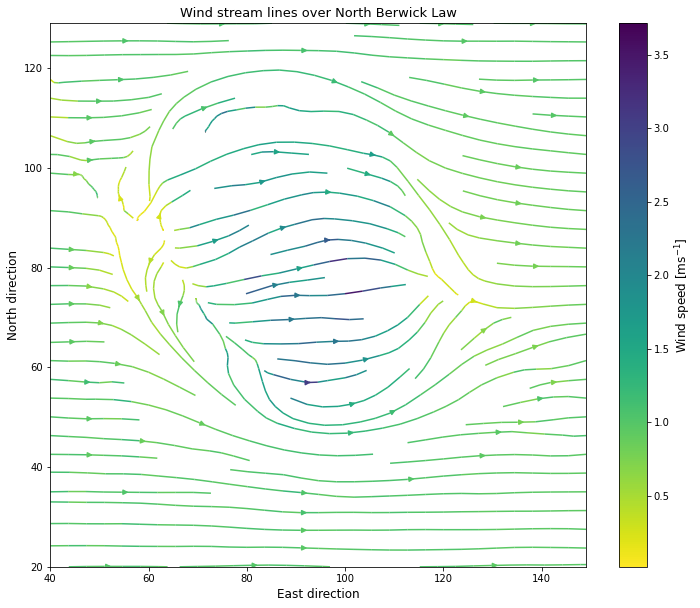

In [4]:
# Wind stream lines over hill

#create stream plot

X = np.arange(0, 256)
Y = np.arange(0, 256)
fig, ax = plt.subplots(figsize=(12, 10))
strm = ax.streamplot(X[40:150], Y[20:130], u[40:150, 20:130], v[40:150, 20:130], color=wind[40:150, 20:130], cmap='viridis_r')


#set colourbar according to wind speed
cbar = fig.colorbar(strm.lines)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)


ax.set_title("Wind stream lines over North Berwick Law", fontsize = 13)
ax.set_xlabel("East direction", fontsize = 12)
ax.set_ylabel("North direction", fontsize = 12)

plt.show()

# a bit confusing as I get a max wind speed of 8m/s for the wind speed
# but here only a max of around 3.5 (is the 8m/s somewhere at the edges?)


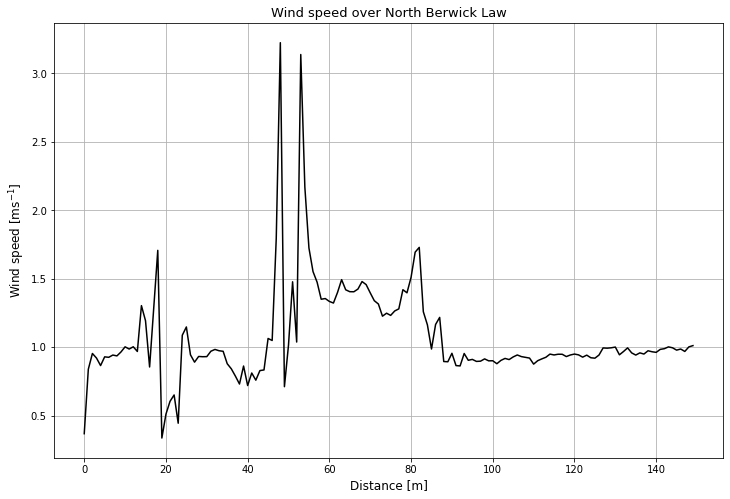

In [5]:
# Wind speed over top of hill
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(wind[128,0:150], c = "k")
ax.set_title("Wind speed over North Berwick Law", fontsize = 13)
ax.set_xlabel("Distance [m]", fontsize = 12)
ax.set_ylabel("Wind speed [ms$^{-1}$]", fontsize = 12)
ax.grid()

# The graph is a lot less clear than the one with the 25 m DTM data
# due to the higher resolution data I gues

Text(0.5, 1.0, 'Vertical wind component over summit of North Berwick Law')

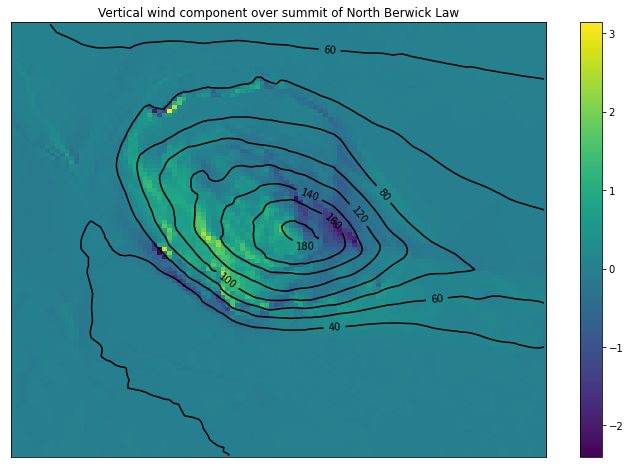

In [6]:
# Plot vertical wind component and topography for 1 km x 1 km area centred on the summit
plt.figure(figsize=(12,8))
plt.imshow(w[40:150, 20:130],origin='lower', aspect='auto')  # north at the top of the image
plt.colorbar()
cs = plt.contour(z[40:150, 20:130],colors='k',levels=np.arange(0,1000,20))
plt.clabel(cs,fmt='%d')
cbar.ax.set_ylabel('Vertical wind component speed [ms$^{-1}$]', fontsize = 12)
plt.xticks([])
plt.yticks([])

plt.title("Vertical wind component over summit of North Berwick Law")

# This plot clearly shows the higher resolution of the LiDAR data

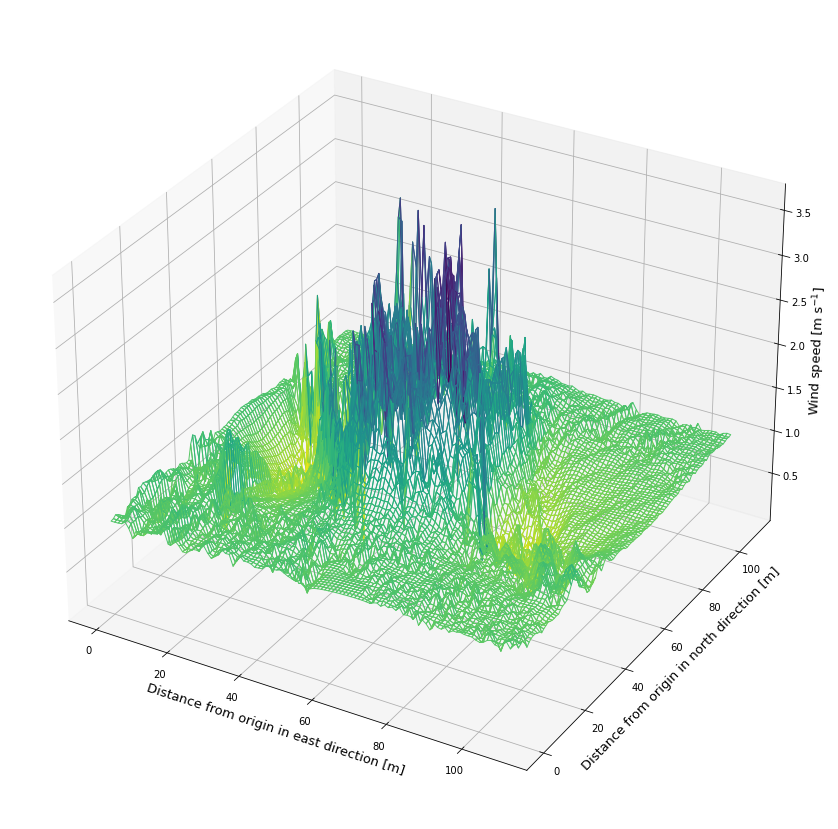

In [7]:
# Wind speed 3d plot around the hill

from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

#%matplotlib notebook
def surface_plot(data):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(0, 110)
    y = np.arange(0, 110)
    X, Y = np.meshgrid(x, y)

    # Normalize to [0,1]
    Z = data[40:150, 20:130]
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis_r(norm(Z))
    rcount, ccount, _ = colors.shape
    

    surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
                           facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))
    


    ax.set_xlabel('Distance from origin in east direction [m]', fontsize=13)
    ax.set_ylabel('Distance from origin in north direction [m]', fontsize=13)
    ax.set_zlabel('Wind speed [m s$^{-1}$]', fontsize=13)
    
surface_plot(wind)

# is very messy

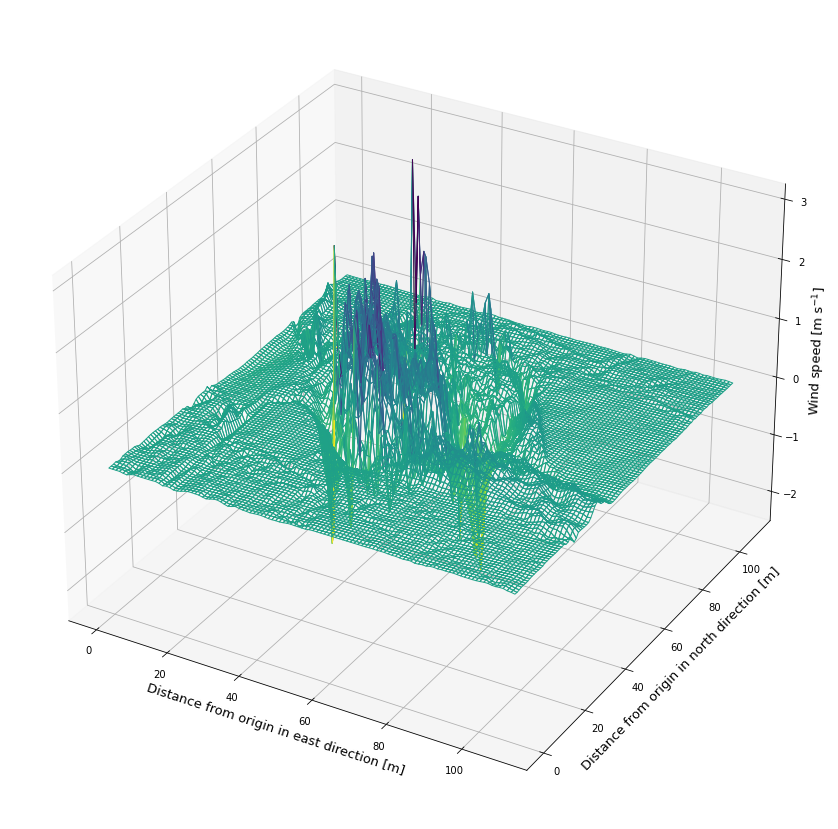

In [8]:
# 3D plot of Vertical wind speed component (w)

surface_plot(w)